In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 12
import os
import subprocess
# Because Collab Jupyter Notebooks are headless, we need to launch a simple
# Xserver on DISPLAY :42 to use Mayavi/VTK Rendering
xvfbcommand = "Xvfb :42 -screen 0 1280x1024x24 -auth localhost".split(" ")
subprocess.Popen(['nohup'] + xvfbcommand,
                 stdout=open('/dev/null', 'w'),
                 stderr=open('/tmp/xvfb-logfile.log', 'a'),
                 preexec_fn=os.setpgrp
                 )
os.environ["DISPLAY"] = ":42"
from mayavi import mlab
mlab.init_notebook()

from netCDF4 import Dataset
import numpy as np
import sys
for pap in ["/home/lahaye/Coding/"+pa for pa in ["Py3_ROMS_Modules","Python_ROMS_Modules/lahaye"]]:
    if pap not in sys.path: sys.path.append(pap)
import R_tools_fort as toolf
import R_tools as tools
import comp_zlevs as zlev

KRYPTON = "/data0/project/vortex/lahaye/"

Notebook initialized with x3d backend.


In [2]:
simul = "luckyto"
path_data = "{}_ebl3D_j485_i513_avg.nc".format(simul)
path_grid = KRYPTON + "lucky_corgrd.nc"

picdir = "pictures/"

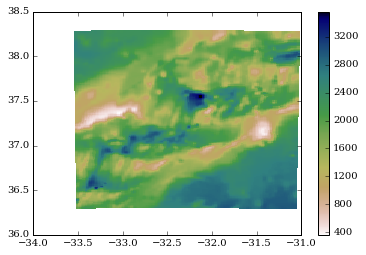

In [3]:
# load data
nc = Dataset(path_data, "r")
ncvar = nc.variables
xi = ncvar['xi'][:]
eta = ncvar['eta'][:]
lon = ncvar['lon'][:]
lat = ncvar['lat'][:]
kebc = ncvar['ebcl'][:]
nc.close()
lonm, latm = lon.mean(axis=0), lat.mean(axis=1)

nc = Dataset(path_grid, "r")
topo = nc.variables['h'][eta,:][:,xi]
nc.close()
Ny, Nx = topo.shape

plt.pcolormesh(lon, lat, topo, cmap='gist_earth_r')
plt.colorbar()

In [4]:
hc = 300.
Cs_r, Cs_w = zlev.get_scoord(hc, 6, 4, 80)
zr, zw = toolf.zlevs(topo.T, np.zeros(topo.T.shape), hc, Cs_r, Cs_w)
#zlev.zlev_rho(topo.T, np.zeros(topo.T.shape), hc, Cs_r)
zabr = zr + topo.T[...,None]
zabw = zw + topo.T[...,None]

zmin = zabr.min()
print(zmin)

mab = np.array([10, 50, 100, 100, 200, 300, 400, 500, 600, 750, 1000])
zint = mab[None,None,:] - topo.T[...,None]

ke_ab = tools.vinterp(kebc.T, zint, zr, zw, interp_sfc=0, interp_bot=0).T


1.617978511244985


/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


0, 1, 2, 3, 4, 5, 

/usr/lib/python3/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


6, 7, 8, 9, 10, 

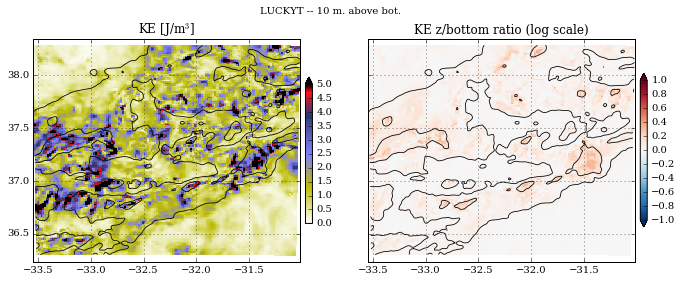

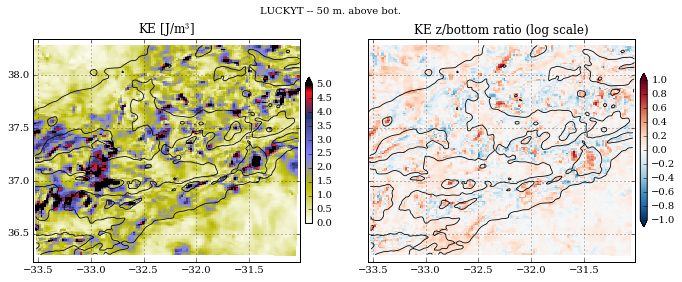

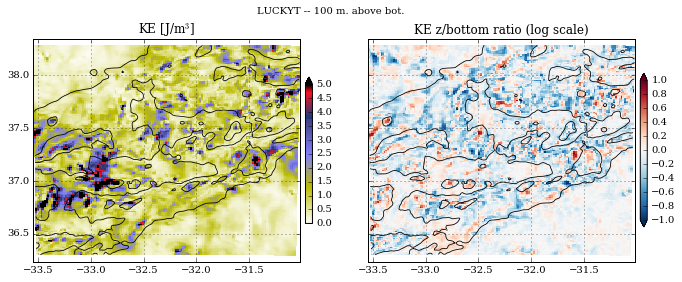

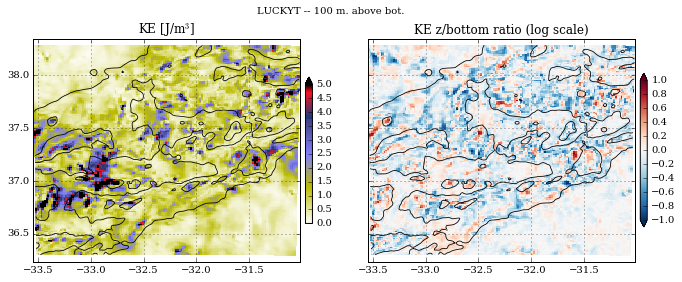

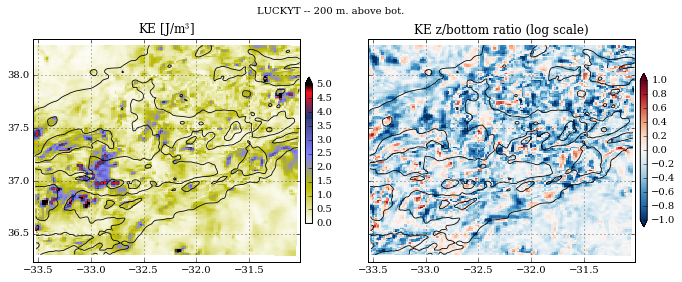

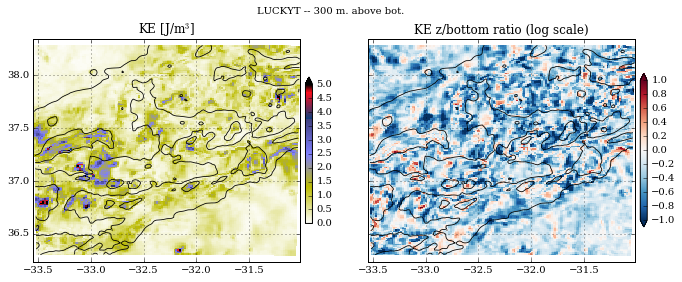

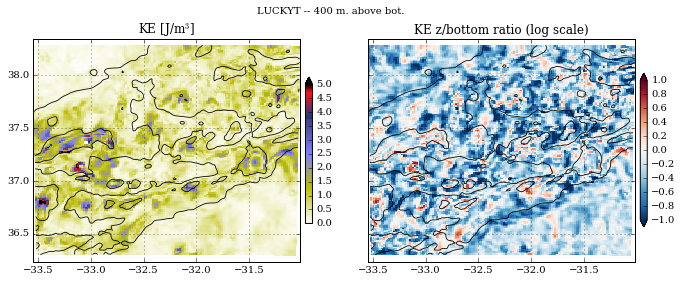

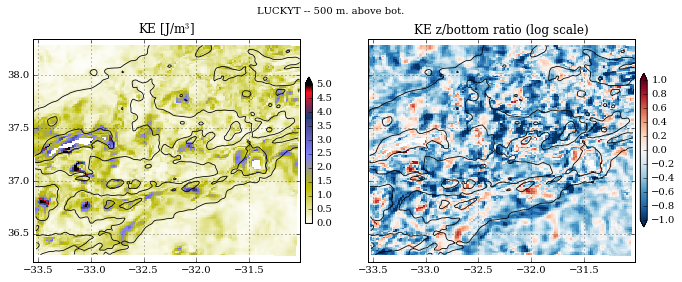

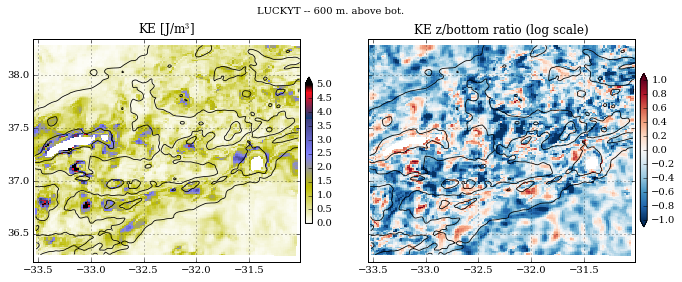

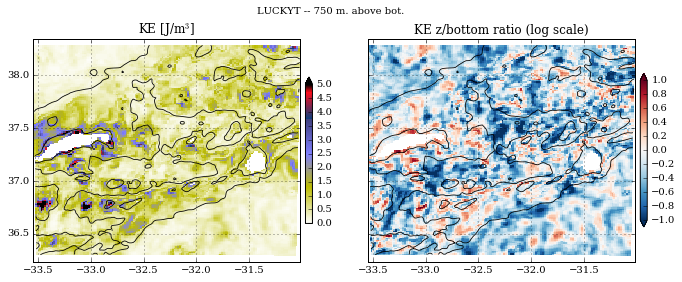

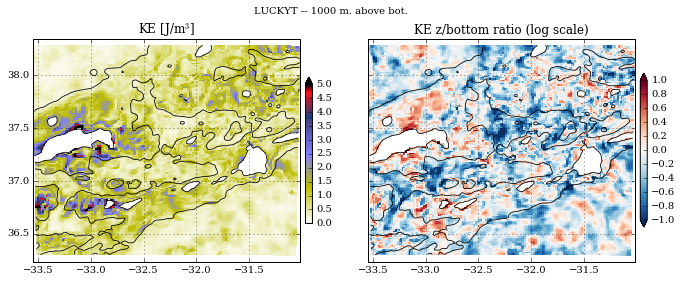

In [5]:
cmap = "RdBu_r"
vmin, vmax = -1, 1
zlevs = [1000, 2000, 3500]

for iz in range(len(mab)):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,4))

    ax = axs[0]
    hpc = ax.pcolormesh(lon, lat, ke_ab[iz,:,:], cmap="gist_stern_r", vmin=0, vmax=5)
    plt.colorbar(hpc, ax=ax, extend="max", fraction=.025, pad=.02)
    hct = ax.contour(lon, lat, topo, levels=zlevs, colors="k", linewidths=0.8)
    for item in hct.collections:
        item.set_rasterized(True)

    ax = axs[1]
    hpc = ax.pcolormesh(lon, lat, np.log10(ke_ab[iz,:,:]/kebc[0,:,:]), cmap="RdBu_r", vmin=-1, vmax=1)
    plt.colorbar(hpc, ax=ax, extend="both", fraction=.025, pad=.02)
    hct = ax.contour(lon, lat, topo, levels=zlevs, colors="k", linewidths=0.8)
    for item in hct.collections:
        item.set_rasterized(True)

    for ax in axs:
        ax.set_aspect("equal")
        ax.grid(True)
        ax.set_xlim([lon.min(),lon.max()])
        ax.set_ylim([lat.min(),lat.max()])

    axs[0].set_title(r'KE [J/m$^3$]')
    axs[1].set_title(r'KE z/bottom ratio (log scale)')
    plt.suptitle(r'{0} -- {1:0d} m. above bot.'.format(simul.upper(),int(mab[iz])), y=1.01)

    fig.savefig(picdir+"{0}_KEbc_{1:02d}mab.png".format(simul,int(mab[iz])), magnification="auto", bbox_inches="tight", dpi=150)
    print(iz, end=", ")
#fig.set_tight_layout(True)

In [5]:
# interpolate on regular grid for plotting
Nzp = 100
zplot = np.linspace(zr.min(), -100, 100)
kepl = tools.vinterp(kebc.T, zplot, zr, zw, interp_sfc=0, interp_bot=0)

xpl, ypl, zpl = np.mgrid[0:Nx,0:Ny,0:len(zplot)]

Notebook initialized with png backend.
80 None x y



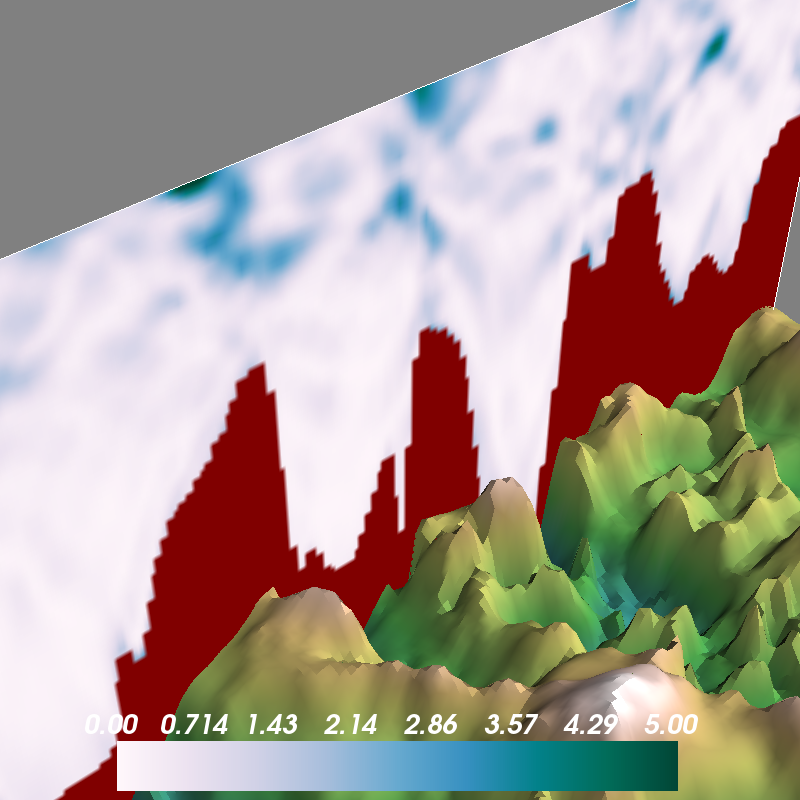

In [34]:
#ia = 55 # 85 #
ia = 80 #98 #
plane = "x"
planb = "y" if plane == "x" else "x"
ib = None#86 #
cmap = "PuBuGn"

mlab.init_notebook("png") #
print(ia, ib, plane, planb)

fig = mlab.figure(size=(800,800))
x2d, y2d = np.mgrid[0:Nx,0:Ny]
s = mlab.surf(x2d, y2d, (-topo.T-zr.min())/(-100-zr.min())*Nzp/2, colormap="gist_earth")#color=(0.6,0.6,0.6))
#for iy in iys:
hpv = mlab.volume_slice(xpl, ypl, zpl, kepl, slice_index=ia, plane_orientation=plane+"_axes"\
                  , colormap=cmap, vmin=0, vmax=5, transparent=True)
mlab.colorbar(hpv)
if ib is not None:
    mlab.volume_slice(xpl, ypl, zpl, kepl, slice_index=ib, plane_orientation=planb+"_axes"\
                  , colormap=cmap, vmin=0, vmax=5, transparent=True)
mlab.view(azimuth=140, elevation=-50, distance=200, focalpoint="auto")

s


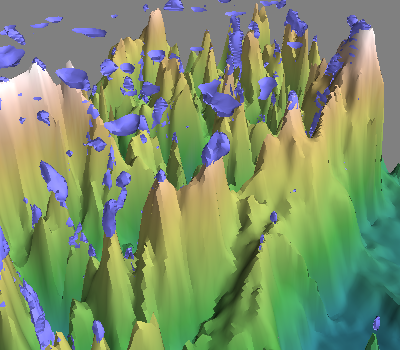

In [106]:
# contour3d plot
mlab.figure()
s = mlab.surf(x2d, y2d, (-topo.T-zr.min())/(-100-zr.min())*Nzp, colormap="gist_earth")
mlab.contour3d(xpl, ypl, zpl, kepl, contours=[4], transparent=True, color=(0.5,0.5,1))
mlab.view(azimuth=60, elevation=-60, distance=200, focalpoint="auto")
s

In [33]:
mlab.savefig('{0}_slice-{1}_{2}_KEbc.png'.format(simul,planb,ia), magnification="auto")

In [202]:
mlab.savefig?